In [45]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

In [ ]:
dataset_path = "../dataset/"

train_dataset = torchvision.datasets.ImageFolder(root=dataset_path + "/train", transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=dataset_path + "/test", transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [49]:
def dataset_info(loader, dataset_name="Dataset"):
    print(f"Dataset: {dataset_name}")
    print(f"Total samples: {len(loader.dataset)}") 

    images, labels = next(iter(loader))
    print(f"Batch size: {images.shape[0]}")
    print(f"Image shape: {images.shape}") 
    print(f"Unique classes: {set(labels.numpy())}")  
    print(f"Total classes: {len(set(labels.numpy()))}") 

dataset_info(train_loader, "Training Set")

Dataset: Training Set
Total samples: 1275
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Unique classes: {0, 1}
Total classes: 2


In [50]:
def train(num_epochs=10):
    train_losses, train_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    return train_losses, train_accuracies

In [51]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [53]:
def evaluate():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

In [ ]:
def predict(image_path):
    from PIL import Image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        print(output)
        _, predicted = output.max(1)
    print(f'Predicted Class: {predicted.item()}')
    return predicted.item()

In [55]:
def plot_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

##################################################
Training Started
Epoch 1, Loss: 0.4756, Accuracy: 77.96%
Epoch 2, Loss: 0.4324, Accuracy: 81.73%
Epoch 3, Loss: 0.4157, Accuracy: 81.57%
Epoch 4, Loss: 0.5005, Accuracy: 77.65%
Epoch 5, Loss: 0.4091, Accuracy: 81.25%
Epoch 6, Loss: 0.3938, Accuracy: 83.29%
Epoch 7, Loss: 0.3567, Accuracy: 84.86%
Epoch 8, Loss: 0.3481, Accuracy: 86.20%
Epoch 9, Loss: 0.3476, Accuracy: 86.12%
Epoch 10, Loss: 0.3415, Accuracy: 86.27%
Training Completed
##################################################
Model Evaluation Started
Test Accuracy: 85.71%
Model Evaluation Started
##################################################
Plotting the metrics


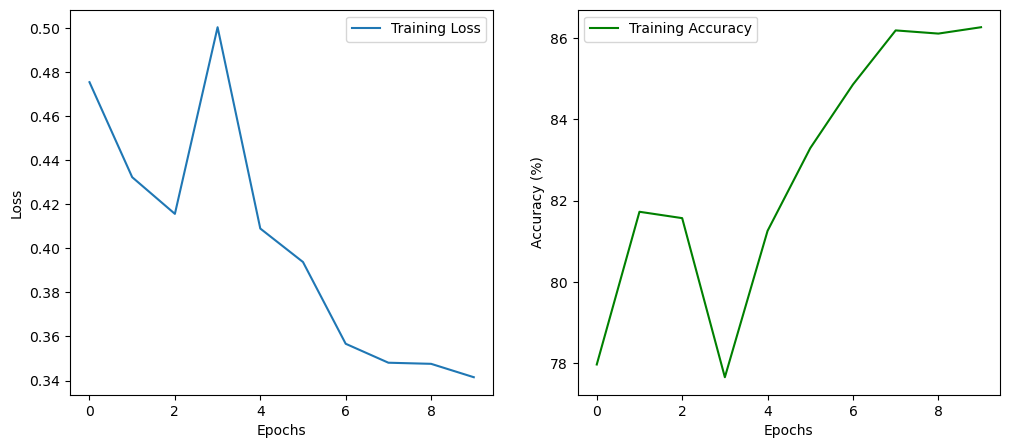

In [73]:
print('#' * 50)
print('Training Started')
train_losses, train_accuracies = train(num_epochs=10)
print('Training Completed')
print('#' * 50)
print('Model Evaluation Started')
evaluate()
print('Model Evaluation Started')
print('#' * 50)
print('Plotting the metrics')
plot_metrics(train_losses, train_accuracies)

In [74]:
predict('../dataset/test/dandelion/3517492544_0fd3ed6a66_m_jpg.rf.023d55ce980d42b59b62acce37f2ffe9.jpg')

tensor([[-2.2120,  2.0357]], device='cuda:0')
tensor([1], device='cuda:0')
Predicted Class: 1


1

In [78]:
predict('../dataset/test/daisy/488202750_c420cbce61_jpg.rf.ebf7d924209a96639fffea69bd279a8c.jpg')

tensor([[ 1.5009, -1.3967]], device='cuda:0')
tensor([0], device='cuda:0')
Predicted Class: 0


0